# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



In [ ]:
Ник на Kaggle: andrewbotalov
После различных экспериментов выбрал варинат с дообучением сети EfficientNet_b4 (самая оптимиальная в соотношении кол-во параметров/точность в imagenet)
с разморозкой трех последних блоков.

### Установка зависимостей

In [ ]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [ ]:
import PIL
print(PIL.__version__)

10.2.0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

ModuleNotFoundError: No module named 'google'

In [ ]:
!rm -rf  /content/testset
!rm -rf  /content/train
!rm -rf  /content/characters_illustration.png
!rm -rf  /content/sample_submission.csv

In [ ]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

In [ ]:
!ls train

simpsons_dataset


In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

"nvidia-smi" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


False

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

import torchvision
from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [ ]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
if torch.cuda.is_available():
  DEVICE = torch.device("cuda")
else:
  DEVICE = torch.device("cpu")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:

            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()

            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path(r'D:\dls_project\src\train')
TEST_DIR = Path(r'D:\dls_project\src\testset')

In [ ]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
Применил аугментацию данных, разделил классы на группы по кол-ву элементов - чем меньше элементов тем больше данных генерится.
Применил горизонтальный разворот и случайное масштабирование с различными масштабами,

In [ ]:
from collections import Counter
labels = [path.parent.name for path in train_files]
counter = dict(Counter(labels))
extra_small_classes = {}
small_classes = {}
mid_classes = {}
huge_classes = {}
for uniq_label in np.unique(labels):
    if counter[uniq_label] < 50:
        extra_small_classes[uniq_label] = 0
    elif counter[uniq_label] < 200:
        small_classes[uniq_label] = 0
    elif counter[uniq_label] < 500:
        mid_classes[uniq_label] = 0
    else:
        huge_classes[uniq_label] = 0

train_files_old = train_files.copy()
for path in train_files_old:
    if path.parent.name in extra_small_classes:
        image = Image.open(path)
        image.load()
        for transform in (transforms.RandomHorizontalFlip(),
                          transforms.RandomCrop(size=(int(0.7 * image.size[1]), int(0.7 * image.size[0]))),
                          transforms.RandomCrop(size=(int(0.7 * image.size[1]), int(0.7 * image.size[0]))),
                          transforms.RandomCrop(size=(int(0.7 * image.size[1]), int(0.7 * image.size[0]))),
                          transforms.RandomCrop(size=(int(0.6 * image.size[1]), int(0.7 * image.size[0]))),
                          transforms.RandomCrop(size=(int(0.6 * image.size[1]), int(0.6 * image.size[0]))),
                          transforms.RandomCrop(size=(int(0.6 * image.size[1]), int(0.6 * image.size[0]))),
                          transforms.RandomRotation(degrees=10),
                          transforms.RandomRotation(degrees=20),
                          transforms.RandomRotation(degrees=30)
                         ):
          extra_small_classes[path.parent.name] += 1
          new_name = 'pic_transform_' + str(extra_small_classes[path.parent.name]).zfill(4)
          new_path = Path(path.parent, new_name + '.jpg')
          image_transform = transform(image)
          image_transform.save(new_path)
          train_files.append(new_path)

    if path.parent.name in small_classes:
        image = Image.open(path)
        image.load()
        for transform in (transforms.RandomHorizontalFlip(),
                          transforms.RandomCrop(size=(int(0.7 * image.size[1]), int(0.7 * image.size[0]))),
                          transforms.RandomCrop(size=(int(0.7 * image.size[1]), int(0.7 * image.size[0]))),
                          transforms.RandomRotation(degrees=15),
                          transforms.RandomRotation(degrees=23)
                         ):
          small_classes[path.parent.name] += 1
          new_name = 'pic_transform_' + str(small_classes[path.parent.name]).zfill(4)
          new_path = Path(path.parent, new_name + '.jpg')
          image_transform = transform(image)
          image_transform.save(new_path)
          train_files.append(new_path)

    if path.parent.name in mid_classes:
        mid_classes[path.parent.name] += 1
        new_name = 'pic_transform_' + str(mid_classes[path.parent.name]).zfill(4)
        new_path = Path(path.parent, new_name + '.jpg')
        image = Image.open(path)
        image.load()
        for transform in (transforms.RandomHorizontalFlip(),
                          transforms.RandomCrop(size=(int(0.7 * image.size[1]), int(0.7 * image.size[0])))):
            image_transform = transform(image)
            image_transform.save(new_path)
            train_files.append(new_path)

    if path.parent.name in huge_classes:
        huge_classes[path.parent.name] += 1
        new_name = 'pic_transform_' + str(huge_classes[path.parent.name]).zfill(4)
        new_path = Path(path.parent, new_name + '.jpg')
        image = Image.open(path)
        image.load()
        image_transform = transforms.RandomHorizontalFlip()(image)
        image_transform.save(new_path)
        train_files.append(new_path)





In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [ ]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions):
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

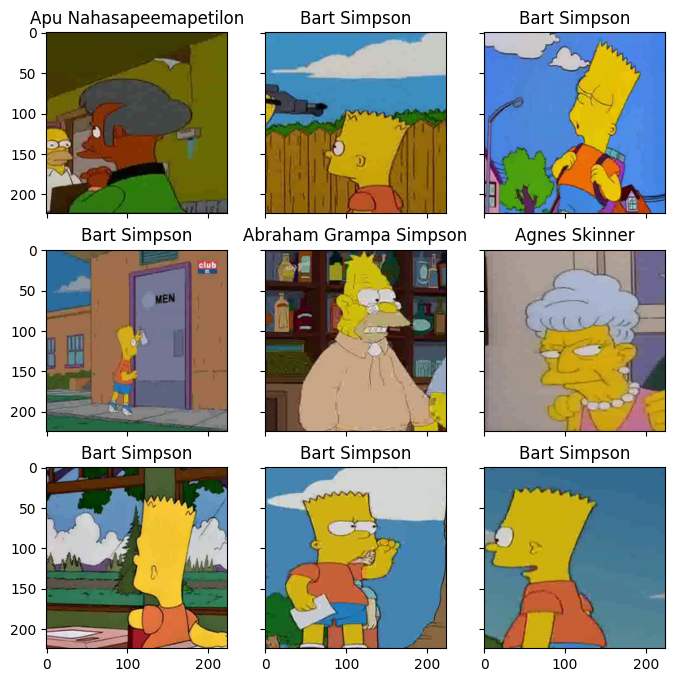

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Попробовал улучшить простую базовую нейросеть, результаты улучшились, но недостаточно

In [ ]:
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.5)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 24 * 24, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(4096, n_classes)
        )


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
Попробовал реализовать что-то вроде упрощенного реснета. В процессе обучения понял, что сеть настраивается недостаточно хорошо на текущем датасете.
Ресурсов на подробное тестирование и тюнинг данной сети не было, т.к. сеть обучается оочень долго

In [ ]:
class SimpleBlock(nn.Module):

    def __init__(self, _in, _out, kernel_size=3, downsampling=False) -> None:
        super().__init__()
        self.downsampling = downsampling
        self.conv1 = nn.Conv2d(in_channels=_in, out_channels=_out, kernel_size=kernel_size, padding=1)
        self.bn1 = nn.BatchNorm2d(_out)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels=_out, out_channels=_out, kernel_size=kernel_size, padding=1)
        self.bn2 = nn.BatchNorm2d(_out)
        if downsampling:
            self.conv3 = nn.Conv2d(in_channels=_in, out_channels=_out, kernel_size=1)
            self.bn3 = nn.BatchNorm2d(_out)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):

        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsampling:
             identity = self.conv3(x)
             identity = self.bn3(identity)

        out += identity
        out = self.relu2(out)

        return out


class SimpsonCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = nn.Sequential(SimpleBlock(64, 64, 3, False), SimpleBlock(64, 64, 3, False))
        self.layer2 = nn.Sequential(SimpleBlock(64, 128, 3, True), SimpleBlock(128, 128, 3, False))
        self.layer3 = nn.Sequential(SimpleBlock(128, 256, 3, True), SimpleBlock(256, 256, 3, False))
        self.layer4 = SimpleBlock(256, 512, 3, True)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Linear(512, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)

        x = x.view(x.size(0), -1)

        x = self.fc(x)

        return x

In [ ]:
Зачем обучать сеть с нуля, если уже обученные сети на большой базе данных. Взял за основу EfficientNet B4,
как хорошую сеть по сотношению кол-во параметров/качество.
Поменял слой классификации и заморозил все блоки кроме двух последних - получилось 5млн обучаемых параметров.

In [ ]:
n_classes = len(np.unique(train_val_labels))
weights = torchvision.models.EfficientNet_B4_Weights.DEFAULT
learned_model = torchvision.models.efficientnet_b4(weights=weights)
learned_model.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(1792, n_classes)
        )

In [ ]:
n_classes = len(np.unique(train_val_labels))
weights = torchvision.models.EfficientNet_B7_Weights.DEFAULT
learned_model = torchvision.models.efficientnet_b7(weights=weights)
learned_model.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(2560, n_classes)
        )

In [ ]:
!pip install torchinfo

In [ ]:
for param in learned_model.features[:-3].parameters():
    param.requires_grad = False

In [ ]:
from torchinfo import summary
summary(model=learned_model,
        input_size=(64, 3, 224, 224)
)

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [64, 42]                  --
├─Sequential: 1-1                                       [64, 1792, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                        [64, 48, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [64, 48, 112, 112]        (1,296)
│    │    └─BatchNorm2d: 3-2                            [64, 48, 112, 112]        (96)
│    │    └─SiLU: 3-3                                   [64, 48, 112, 112]        --
│    └─Sequential: 2-2                                  [64, 24, 112, 112]        --
│    │    └─MBConv: 3-4                                 [64, 24, 112, 112]        (2,940)
│    │    └─MBConv: 3-5                                 [64, 24, 112, 112]        (1,206)
│    └─Sequential: 2-3                                  [64, 32, 56, 56]          --
│    │    └─MBConv: 3-6                    

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
В качестве оптимизатора взял AdamW с weight decay по умолчанию (0.01) и изменением l_r через несколько шагов

In [ ]:
def train(train_loader, val_loader, model, epochs):

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters())
        criterion = nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer=opt, step_size=3, gamma=0.5)

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

            scheduler.step()

    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:

learned_model.to(DEVICE)
print("we will classify :{}".format(n_classes))
print(learned_model)

we will classify :42
EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
         

In [ ]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  

In [ ]:
n_classes = len(np.unique(train_val_labels))
simpson_cnn = SimpsonCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simpson_cnn)

we will classify :42
SimpsonCnn(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): SimpleBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
    )
    (1): SimpleBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (re

Запустим обучение сети.

In [ ]:
Добавил веса в DataLoader, чтобы отбалансить формирование батча на насктолько несбалансированных данных

In [ ]:
from collections import Counter
from torch.utils.data.sampler import WeightedRandomSampler

batch_size = 64
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

train_dataset = SimpsonsDataset(train_files, mode='train')

c = Counter(train_dataset.labels)
weights = np.array([1/c[label] for label in train_dataset.labels])
weights = torch.from_numpy(weights)
sampler = WeightedRandomSampler(weights.type('torch.DoubleTensor'), len(weights))

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)


In [ ]:
#b4, Dropout = 0.2, уменьшение l_r через 2 эпохи, разморозил два последних блока

In [ ]:
history = train(train_loader, val_loader, model=learned_model, epochs=10)

epoch:   0%|                                                                                                                                                             | 0/10 [00:00<?, ?it/s]

loss 0.04665633236940589


epoch:  10%|██████████████▌                                                                                                                                  | 1/10 [40:07<6:01:10, 2407.84s/it]


Epoch 001 train_loss: 0.0467     val_loss 0.3753 train_acc 0.9870 val_acc 0.9161
loss 0.029981899848258022


epoch:  20%|████████████████████████████▌                                                                                                                  | 2/10 [1:21:03<5:24:47, 2435.98s/it]


Epoch 002 train_loss: 0.0300     val_loss 0.3916 train_acc 0.9917 val_acc 0.9209
loss 0.008761358192036134


epoch:  30%|██████████████████████████████████████████▉                                                                                                    | 3/10 [2:02:17<4:46:13, 2453.42s/it]


Epoch 003 train_loss: 0.0088     val_loss 0.3266 train_acc 0.9977 val_acc 0.9326
loss 0.0047068218946301555


epoch:  40%|█████████████████████████████████████████████████████████▏                                                                                     | 4/10 [2:43:33<4:06:14, 2462.39s/it]


Epoch 004 train_loss: 0.0047     val_loss 0.3756 train_acc 0.9986 val_acc 0.9301
loss 0.0014049758418257475


epoch:  50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 5/10 [3:25:17<3:26:26, 2477.37s/it]


Epoch 005 train_loss: 0.0014     val_loss 0.3981 train_acc 0.9996 val_acc 0.9371
loss 0.0006632976319395277


epoch:  60%|█████████████████████████████████████████████████████████████████████████████████████▊                                                         | 6/10 [4:06:22<2:44:51, 2472.91s/it]


Epoch 006 train_loss: 0.0007     val_loss 0.3840 train_acc 0.9998 val_acc 0.9389
loss 0.000683308887135414


epoch:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 7/10 [4:45:54<2:01:59, 2439.92s/it]


Epoch 007 train_loss: 0.0007     val_loss 0.3773 train_acc 0.9998 val_acc 0.9406
loss 0.00027286933702305765


epoch:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 8/10 [5:26:01<1:20:59, 2429.55s/it]


Epoch 008 train_loss: 0.0003     val_loss 0.3923 train_acc 0.9999 val_acc 0.9389
loss 0.0001289164120703769


epoch:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 9/10 [6:08:25<41:05, 2465.48s/it]


Epoch 009 train_loss: 0.0001     val_loss 0.3982 train_acc 0.9999 val_acc 0.9396
loss 0.0001022270360577739


epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [6:50:14<00:00, 2461.48s/it]


Epoch 010 train_loss: 0.0001     val_loss 0.4000 train_acc 0.9999 val_acc 0.9400


In [ ]:
#b4, Dropout 0.2, уменьшение l_r через 3 эпохи, разморозил три последних блока
history = train(train_loader, val_loader, model=learned_model, epochs=10)

epoch:   0%|                                                                                                                                                             | 0/10 [00:00<?, ?it/s]

loss 0.4205811407203692


epoch:  10%|██████████████▏                                                                                                                               | 1/10 [1:21:34<12:14:11, 4894.65s/it]


Epoch 001 train_loss: 0.4206     val_loss 0.2586 train_acc 0.8969 val_acc 0.9408
loss 0.07505688310989807


epoch:  20%|████████████████████████████▍                                                                                                                 | 2/10 [2:35:33<10:16:52, 4626.54s/it]


Epoch 002 train_loss: 0.0751     val_loss 0.2510 train_acc 0.9802 val_acc 0.9486
loss 0.03624983719611724


epoch:  30%|██████████████████████████████████████████▉                                                                                                    | 3/10 [3:48:15<8:45:40, 4505.72s/it]


Epoch 003 train_loss: 0.0362     val_loss 0.3202 train_acc 0.9901 val_acc 0.9270
loss 0.009856093790205708


epoch:  40%|█████████████████████████████████████████████████████████▏                                                                                     | 4/10 [5:01:13<7:25:32, 4455.38s/it]


Epoch 004 train_loss: 0.0099     val_loss 0.2200 train_acc 0.9974 val_acc 0.9570
loss 0.006825925106083948


epoch:  50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 5/10 [6:14:02<6:08:41, 4424.30s/it]


Epoch 005 train_loss: 0.0068     val_loss 0.2529 train_acc 0.9982 val_acc 0.9440
loss 0.007779105032884661


epoch:  60%|█████████████████████████████████████████████████████████████████████████████████████▊                                                         | 6/10 [7:28:19<4:55:41, 4435.31s/it]


Epoch 006 train_loss: 0.0078     val_loss 0.2039 train_acc 0.9978 val_acc 0.9570
loss 0.001972659817530102


epoch:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 7/10 [8:41:41<3:41:12, 4424.28s/it]


Epoch 007 train_loss: 0.0020     val_loss 0.2270 train_acc 0.9994 val_acc 0.9610
loss 0.0014222631064010945


epoch:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 8/10 [9:56:00<2:27:51, 4435.50s/it]


Epoch 008 train_loss: 0.0014     val_loss 0.2374 train_acc 0.9997 val_acc 0.9568
loss 0.0017386221820726248


epoch:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 9/10 [11:09:30<1:13:47, 4427.51s/it]


Epoch 009 train_loss: 0.0017     val_loss 0.2114 train_acc 0.9996 val_acc 0.9603
loss 0.0003101317967523092


epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [12:22:32<00:00, 4455.30s/it]


Epoch 010 train_loss: 0.0003     val_loss 0.2259 train_acc 0.9999 val_acc 0.9614


In [ ]:
#b4, Dropout увеличил до 0.5, повороты в аугментации убрал, уменьшение l_r через 4 эпохи,разморозил два последних блока
history = train(train_loader, val_loader, model=learned_model, epochs=10)

epoch:   0%|                                                                                                                                                             | 0/10 [00:00<?, ?it/s]

loss 0.7855964467961056


epoch:  10%|██████████████▌                                                                                                                                  | 1/10 [38:55<5:50:16, 2335.22s/it]


Epoch 001 train_loss: 0.7856     val_loss 0.4268 train_acc 0.8004 val_acc 0.8833
loss 0.0927642518207778


epoch:  20%|████████████████████████████▌                                                                                                                  | 2/10 [1:13:48<4:52:21, 2192.65s/it]


Epoch 002 train_loss: 0.0928     val_loss 0.3970 train_acc 0.9747 val_acc 0.8972
loss 0.0440724704876477


epoch:  30%|██████████████████████████████████████████▉                                                                                                    | 3/10 [1:59:15<4:44:17, 2436.76s/it]


Epoch 003 train_loss: 0.0441     val_loss 0.4072 train_acc 0.9878 val_acc 0.9077
loss 0.02921978807144981


epoch:  40%|█████████████████████████████████████████████████████████▏                                                                                     | 4/10 [2:45:46<4:17:40, 2576.68s/it]


Epoch 004 train_loss: 0.0292     val_loss 0.3926 train_acc 0.9920 val_acc 0.9094
loss 0.012347095412920317


epoch:  50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 5/10 [3:21:33<3:21:48, 2421.61s/it]


Epoch 005 train_loss: 0.0123     val_loss 0.3468 train_acc 0.9969 val_acc 0.9240
loss 0.006587312335600634


epoch:  60%|█████████████████████████████████████████████████████████████████████████████████████▊                                                         | 6/10 [3:56:46<2:34:26, 2316.65s/it]


Epoch 006 train_loss: 0.0066     val_loss 0.3732 train_acc 0.9985 val_acc 0.9209
loss 0.00365167548068839


epoch:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 7/10 [4:31:55<1:52:26, 2248.92s/it]


Epoch 007 train_loss: 0.0037     val_loss 0.4002 train_acc 0.9989 val_acc 0.9213


epoch:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 7/10 [4:40:53<2:00:22, 2407.66s/it]


KeyboardInterrupt: 

In [ ]:
#b7, Dropout 0.2, повороты в аугментации убрал, уменьшение l_r через 3 эпохи
history = train(train_loader, val_loader, model=learned_model, epochs=10)

epoch:   0%|                                                                                                                                                             | 0/10 [00:00<?, ?it/s]

loss 0.8303115257815117


epoch:  10%|██████████████▏                                                                                                                               | 1/10 [1:07:44<10:09:41, 4064.63s/it]


Epoch 001 train_loss: 0.8303     val_loss 0.6731 train_acc 0.8165 val_acc 0.8194
loss 0.1509632901000517


epoch:  20%|████████████████████████████▌                                                                                                                  | 2/10 [2:05:47<8:16:17, 3722.23s/it]


Epoch 002 train_loss: 0.1510     val_loss 0.5970 train_acc 0.9629 val_acc 0.8451
loss 0.06952083130826253


epoch:  30%|██████████████████████████████████████████▉                                                                                                    | 3/10 [3:03:41<7:01:03, 3609.07s/it]


Epoch 003 train_loss: 0.0695     val_loss 0.6358 train_acc 0.9832 val_acc 0.8384
loss 0.03542513351945552


epoch:  40%|█████████████████████████████████████████████████████████▏                                                                                     | 4/10 [4:01:33<5:55:29, 3554.85s/it]


Epoch 004 train_loss: 0.0354     val_loss 0.5390 train_acc 0.9916 val_acc 0.8638
loss 0.02094822687731712


epoch:  50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 5/10 [4:59:25<4:53:45, 3525.06s/it]


Epoch 005 train_loss: 0.0209     val_loss 0.5558 train_acc 0.9960 val_acc 0.8657


epoch:  50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 5/10 [5:15:25<5:15:25, 3785.15s/it]


KeyboardInterrupt: 

Построим кривые обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

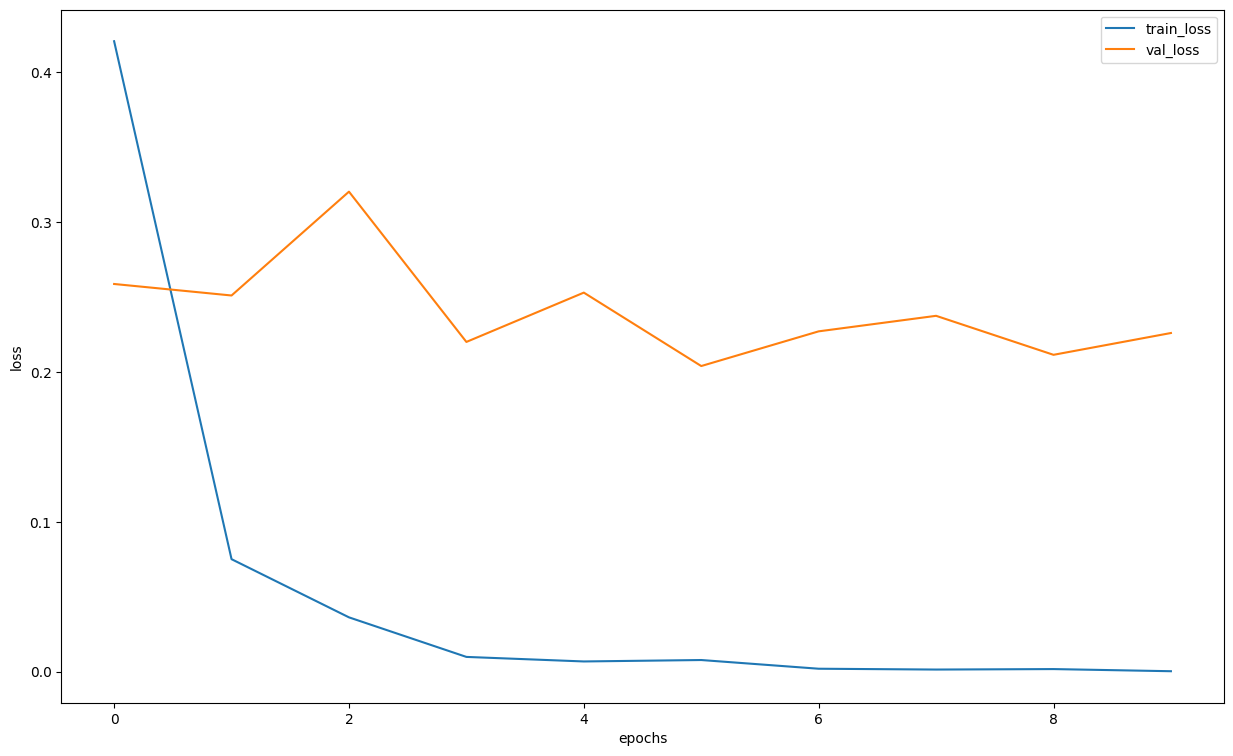

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит.
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(learned_model, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(learned_model, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)


F1-оценка: 1.0


Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

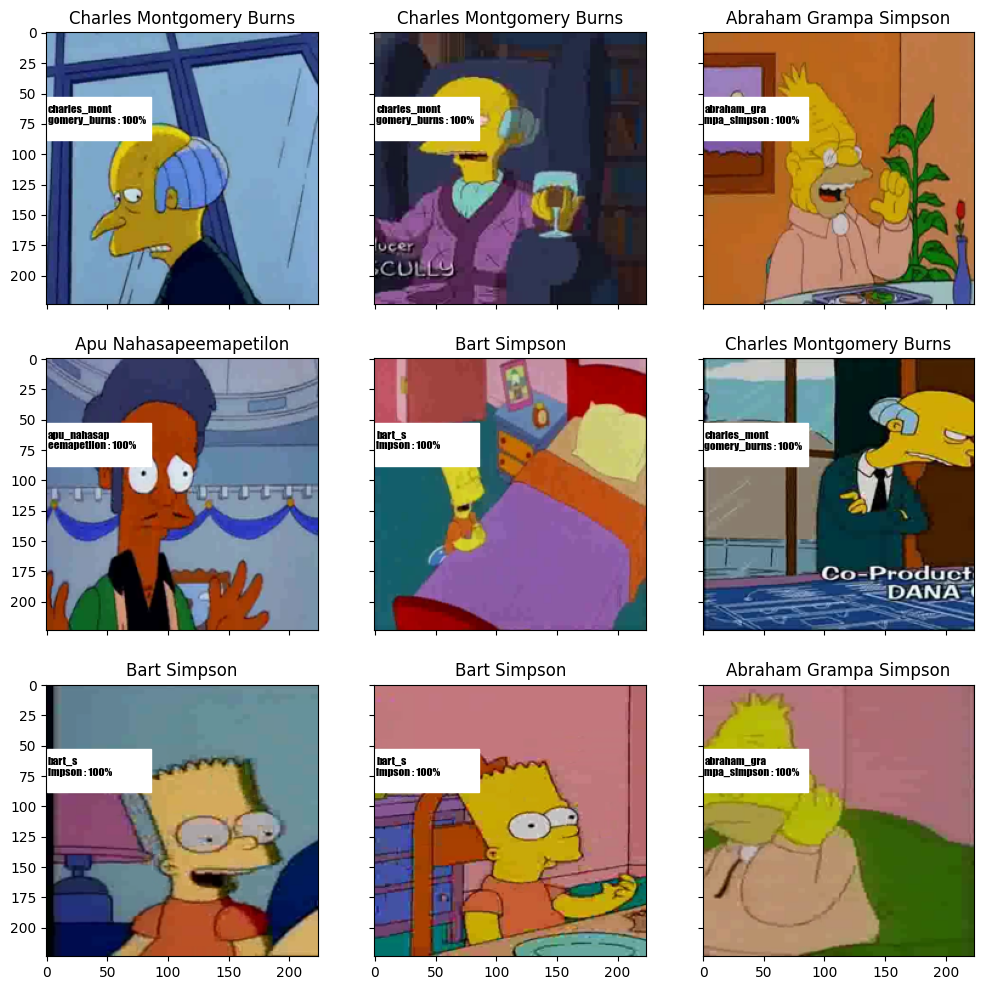

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(learned_model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(learned_model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
! ls

"ls" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [ ]:
import pandas as pd
#my_submit = pd.read_csv(r"D:\dls_project\src\sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [ ]:
my_submit.to_csv('b4_v2_baseline.csv', index=False)

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать.

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову:


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)
